# SVM Kernels

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import cvxopt
import cvxopt.solvers

from tqdm.notebook import tqdm
np.set_printoptions(linewidth=200, suppress=True, formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
df = pd.read_csv('../../Data/OASIS/oasis_3.csv')
print(df.shape)

(2168, 22)


In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
df.loc[df['Diagnosis'] == 'control', 'Diagnosis'] = -1
df.loc[df['Diagnosis'] == 'dementia', 'Diagnosis'] = 1
df['M/F'].replace(['M','F'], [0,1], inplace=True)
df = df.drop(['MR ID', 'Freesurfer ID', 'cdr'], axis=1) # Drop categorical and redundant columns
print(df.shape)

(1022, 18)


In [5]:
df.head()

,Diagnosis,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,
OAS30001,-1,1,73.0,30.0,23.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,-1,0,73.0,29.0,34.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,-1,1,66.0,29.0,33.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,-1,1,61.0,30.0,23.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,-1,1,54.0,30.0,33.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


# PCA

In [6]:
class PCA:
    """
    Applies PCA and also scales the data. Scaling and all transformations will be done 
    based on the dataset that is passed into the fit() method.
    """
    
    def __init__(self, top_k=None):
        """
        Intializes the PCA class
        :param top_k: the number used when PCA picks the top k eigenvectors to use, 
                      None if the PCA will decide by itself
        :principal_components: will store the principal components to be used
        :fitted: boolean, storing whether the pca has been fitted or not yet
        """
        self.top_k = top_k
        self.principal_components = None
        self.fitted = False
    
    def fit(self, X, threshold=0.95):
        """
        Fits the PCA by finding and storing the top k eigenvectors
        :param X: n x d dataset, where d represents the number of features.
        :param standardized: boolean, tells if the dataset X is standardized or not
        :param threshold: the explained variance threshold to select the top_k value
        """
        # Exception and set fitted to true if not
        if self.fitted == True:
            raise Exception('This PCA has already been fitted.')
        self.fitted = True
        
        # Standardize/scale the data and save the means
        self.mu = np.mean(X)
        self.sigma = np.std(X)
        X = (X-self.mu)/self.sigma
        
        # Create the covariance matrix
        cov = np.cov(X.T)
        
        # Perform eigendecomposition on the covariance matrix
        eig_vals, eig_vecs = np.linalg.eig(cov)
        
        variance = 0
        
        # If top_k value was inputted, we compute it ourselves based on the data
        if self.top_k == None:
            # Find the best number of components that pass the threshold
            if threshold > 1:
                threshold /= 100
            total = sum(eig_vals)
            explained_variance = [(i / total) for i in sorted(eig_vals, reverse=True)]
            cumulative_explained_variance = np.cumsum(explained_variance)
            self.top_k = np.argmax(cumulative_explained_variance > threshold) + 1
            variance = cumulative_explained_variance[self.top_k-1]
        
        # Pair up the eigenvectors and eigenvalues as (eigenvalue, eigenvector) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs.T[i,:]) for i in range(len(eig_vals))]

        # Sort the tuples in descending order
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        self.principal_components = np.array([pair[1] for pair in eig_pairs[0:self.top_k]])
        print(f"-- PCA succesfully fitted on dataset. Dimensions reduced from {X.shape[1]} to {self.top_k}, capturing {variance*100:.2f}% of the explained variance. --")
        
    def transform(self, X):
        """
        Project the data onto the new feature space
        :param X: n x d dataset, where d represents the number of features.
        :param standardized: boolean, tells if the dataset X is standardized or not
        :return X_pca: the resulting transformed dataset
        """
        # Checks if fit() has been called
        if self.fitted == False:
            raise Exception('You must call fit() prior to calling transform.')
            
        # Scale the data based on the mu that was saved
        X = (X-self.mu)/self.sigma
        
        # Apply PCA transformation
        X_pca = np.dot(X, self.principal_components.T)
        print(f"-- PCA transformation succesfully applied on dataset. Dimensions reduced from {X.shape[1]} to {X_pca.shape[1]}. --")
        return X_pca
    
    def fit_transform(self, X, threshold=0.95):
        self.fit(X, threshold=threshold)
        return self.transform(X)

## Kernel SVM

In [7]:
class SVM():
    
    # Kernels
    # https://scikit-learn.org/stable/modules/metrics.html#linear-kernel
    def linear(self, xi, xj):
        return np.dot(xi.T, xj)
    
    def polynomial(self, xi, xj):
        return (self.gamma * np.dot(xi.T, xj) + self.c0) ** self.p
    
    def sigmoid(self, xi, xj):
        return np.tanh(self.gamma * np.dot(xi.T, xj) + self.c0)

    def rbf(self, xi, xj):
        return np.exp(-1 * self.gamma * np.dot(xi - xj, xi - xj))
    
    # Default parameters are based on the sklearn SVC
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    def __init__(self, kernel='linear', gamma=None, C=1.0, coef0=0.0, degree=3, verbose=False, max_iter=1000):
        # Setting the parameters for kernels
        self.gamma = gamma
        self.c0 = coef0  # c0 parameter for poly and sigmoid
        self.p = degree  # degree for poly
        
        # Setting the C parameter for soft/hard margin SVM
        # if C is None, it's hard margin, else it's soft
        # the SVM's 'softness' decreases as C increases
        self.C = C
        
        # Setting parameters for SVM in general
        self.verbose = verbose
        self.max_iters = max_iter
        
        # Setting the correct kernel
        self.kernel = kernel
        if kernel == 'linear':
            self.kf = self.linear
        elif kernel == 'poly':
            self.kf = self.polynomial
        elif kernel == 'sigmoid':
            self.kf = self.sigmoid
        elif kernel == 'rbf':
            self.kf = self.rbf
        else:
            raise Exception(f'Invalid kernel inputted: {kernel}')
        
        # Indicates if the SVM is fitted or not
        self.fitted = False
        
        # Set the initial SVM variables
        self._sv_X = None
        self._sv_y = None
        self._alphas = None
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        """
        cvxopt solves the problem:
            min F(x) = 1/2 x.T * P * x + q.T * x
            subject to:
                Gx <= h
                Ax = b
                
        if we let H_ij = yi * yj * xi . xj, our problem becomes:
            min F(x) = 1/2 x.T * H * x - 1.T * x
            subject to:
                -lambda_i <= 0
                lambda_i <= C
                y.T * x = 0
            
        substituting this into the cvxopt problem, we now know that:
            K = kernel function, for linear its xi . xj
            P = H, a matrix of size n_samples, n_samples
                this is calculated by doing yi * yj * K
            q = a vector of size n_samples, filled with -1
            G = diagonal matrix of -1s and 1s
            h = vector filled with zeros and C
            A = the labels y, of size n_samples
            b = the scalar value 0
        """
            
        X = np.array(X)
        y = np.array(y)
        
        n_samples, n_features = X.shape
        
        if self.gamma == None:
            self.gamma = 1.0/(n_features * X.var())
            
        # Calculate the gram matrix for kernel
        K = np.zeros(shape=(n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kf(X[i], X[j])
                
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        # Sets the value of G and h based on C
        if self.C is None:
            # Hard margin SVM
            G = cvxopt.matrix(-np.eye(n_samples))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # Soft margin SVM
            G = cvxopt.matrix(np.vstack((-np.eye(n_samples),
                                        np.eye(n_samples))))
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples),
                                        np.ones(n_samples) * self.C)))
        
        # Set parameters for cvxopt
        cvxopt.solvers.options['maxiters'] = self.max_iters
        if self.verbose == False:
            cvxopt.solvers.options['show_progress'] = False
        
        # Solve the QP problem with cvxopt
        try:
            solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        except Exception as e:
            raise Exception(f"Impossible to fit. CVXOPT raised exception: {e}")
            return
        
        # Pull out the Lagrange multipliers
        alphas = np.ravel(solution['x'])
        
        # Get the indices of the support vectors, which will have Lagrange multipliers that are greater than zero
        sv = alphas > 1e-5
        self._sv_X = X[sv]
        self._sv_y = y[sv]
        self._alphas = alphas[sv]
        
        # Compute the bias/intercept
        # b = 1/N_s * sum_s(y_s - sum_m(alphas_m * y_m * K(x_m, x_s)))
        sv_idx = np.arange(len(alphas))[sv]
        self.b = 0
        for i in range(len(self._alphas)):
            self.b += self._sv_y[i]
            self.b -= np.sum(self._alphas * self._sv_y * K[sv_idx[i], sv])
        self.b /= len(self._alphas)
        
        # Compute the weight vector if kernel is linear
        # w = sum(alphas_i * y_i * x_i)
        if self.kernel == 'linear':
            self.w = np.zeros(n_features)
            for i in range(len(self._alphas)):
                self.w += self._alphas[i] * self._sv_X[i] * self._sv_y[i]
        else:
            self.w = None
        
        # Print results
        if self.verbose:
            print(f'{len(self._alphas)} support vectors found out of {n_samples} data points')
            print(f'Calculated the intercept/bias: b = {self.b}')
            print(f'Calculated the weight vector for {self.kernel} kernel: w = {self.w}')
            
        self.fitted = True
    
    def project(self, X):
        # Check if SVM has been fitted yet
        if self.fitted == False:
            raise Exception('SVM is not fitted')
        
        # Calculate the projection
        if self.kernel == 'linear':
            # This is when self.w is not none
            return np.dot(X, self.w) + self.b
        else:
            # The rest of the kernels
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for alphas, sv_y, sv_X in zip(self._alphas, self._sv_y, self._sv_X):
                    s += alphas * sv_y * self.kf(X[i], sv_X)
                predictions[i] = s
            return predictions + self.b

    def predict(self, X):
        # Predict the class of X
        # yi = sign(alpha_i * y_i * K(x_i, x) + b
        return np.sign(self.project(X))

## Steps in applying it to data
1. Split the data into **train** and **test** sets
2. Fit PCA and/or z-score scaling on the **train** set
3. Apply transformations to the **train** set and the **test** set, using the fitted PCA/z-score from **train** set
4. Train SVM using the **train** set
5. Apply SVM to **test** set to get the accuracy and/or results

#### Step 1 - Split the data into **train** and **test** set

In [8]:
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis'].astype('d')  # cast it to type 'd' for cvxopt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(817, 17) (205, 17) (817,) (205,)


#### Step 2 - Fit PCA and/or z-score scaling on the **train** set

In [9]:
# The PCA also does the scaling
pca = PCA()
pca.fit(X_train, threshold=.99)

-- PCA succesfully fitted on dataset. Dimensions reduced from 17 to 10, capturing 99.58% of the explained variance. --


#### Step 3 - Apply transformations to the **train** set and the **test** set, using the fitted PCA/z-score from **train** set

In [10]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

-- PCA transformation succesfully applied on dataset. Dimensions reduced from 17 to 10. --
-- PCA transformation succesfully applied on dataset. Dimensions reduced from 17 to 10. --


#### Step 4 - Train SVM using the **train** set
#### Step 5 - Apply SVM to **test** set to get the accuracy and/or results

     pcost       dcost       gap    pres   dres
 0: -3.8339e+02 -2.9137e+03  2e+04  4e+00  1e-13
 1: -2.4461e+02 -2.2095e+03  4e+03  7e-01  8e-14
 2: -2.0425e+02 -1.0232e+03  1e+03  1e-01  5e-14
 3: -2.1429e+02 -3.9882e+02  2e+02  2e-02  4e-14
 4: -2.3611e+02 -3.3868e+02  1e+02  9e-03  5e-14
 5: -2.4437e+02 -3.1665e+02  8e+01  6e-03  5e-14
 6: -2.5394e+02 -2.9243e+02  4e+01  3e-03  6e-14
 7: -2.5568e+02 -2.8888e+02  3e+01  2e-03  5e-14
 8: -2.6053e+02 -2.7868e+02  2e+01  7e-04  6e-14
 9: -2.6371e+02 -2.7325e+02  1e+01  3e-04  6e-14
10: -2.6618e+02 -2.6911e+02  3e+00  7e-05  7e-14
11: -2.6695e+02 -2.6788e+02  9e-01  1e-05  6e-14
12: -2.6728e+02 -2.6747e+02  2e-01  1e-06  7e-14
13: -2.6736e+02 -2.6738e+02  2e-02  1e-07  7e-14
14: -2.6737e+02 -2.6737e+02  3e-04  2e-09  7e-14
15: -2.6737e+02 -2.6737e+02  3e-06  2e-11  6e-14
Optimal solution found.
273 support vectors found out of 817 data points
Calculated the intercept/bias: b = -0.25387173026065435
Calculated the weight vector for linear

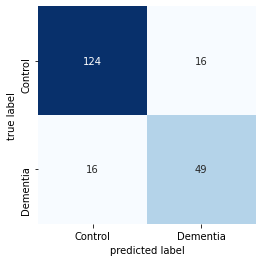

In [11]:
# Linear kernel
svc = SVM(verbose=True, kernel='linear')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)
correct_preds = np.sum(preds == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label')

     pcost       dcost       gap    pres   dres
 0: -4.1033e+02 -2.1023e+03  1e+04  3e+00  4e-14
 1: -3.0056e+02 -1.6748e+03  3e+03  7e-01  2e-14
 2: -2.6840e+02 -1.3155e+03  2e+03  4e-01  1e-14
 3: -2.5631e+02 -7.3271e+02  6e+02  1e-01  9e-15
 4: -2.7265e+02 -4.3022e+02  2e+02  3e-02  8e-15
 5: -2.9422e+02 -3.4802e+02  6e+01  7e-03  8e-15
 6: -3.0247e+02 -3.2965e+02  3e+01  2e-03  1e-14
 7: -3.0837e+02 -3.1744e+02  9e+00  5e-04  1e-14
 8: -3.1053e+02 -3.1361e+02  3e+00  5e-15  1e-14
 9: -3.1155e+02 -3.1221e+02  7e-01  2e-15  1e-14
10: -3.1180e+02 -3.1187e+02  7e-02  2e-15  1e-14
11: -3.1183e+02 -3.1183e+02  3e-03  1e-14  1e-14
12: -3.1183e+02 -3.1183e+02  5e-05  6e-15  9e-15
Optimal solution found.
375 support vectors found out of 817 data points
Calculated the intercept/bias: b = -0.3185932742662826
Calculated the weight vector for poly kernel: w = None
Accuracy: 0.8292682926829268


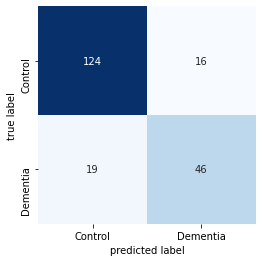

In [12]:
# Poly kernel
svc = SVM(verbose=True, kernel='poly')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)
correct_preds = np.sum(preds == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');

     pcost       dcost       gap    pres   dres
 0: -3.1085e+02 -1.9991e+03  1e+04  3e+00  4e-15
 1: -2.0771e+02 -1.2720e+03  1e+03  2e-01  3e-15
 2: -2.2265e+02 -4.0961e+02  2e+02  2e-02  2e-15
 3: -2.5407e+02 -3.1280e+02  6e+01  5e-03  2e-15
 4: -2.6390e+02 -2.9386e+02  3e+01  2e-03  2e-15
 5: -2.7056e+02 -2.8089e+02  1e+01  5e-04  2e-15
 6: -2.7327e+02 -2.7616e+02  3e+00  1e-04  2e-15
 7: -2.7422e+02 -2.7462e+02  4e-01  2e-15  3e-15
 8: -2.7439e+02 -2.7441e+02  2e-02  9e-15  3e-15
 9: -2.7440e+02 -2.7440e+02  6e-04  1e-14  3e-15
10: -2.7440e+02 -2.7440e+02  1e-05  2e-14  3e-15
Optimal solution found.
353 support vectors found out of 817 data points
Calculated the intercept/bias: b = 0.08212598424605347
Calculated the weight vector for rbf kernel: w = None
Accuracy: 0.8439024390243902


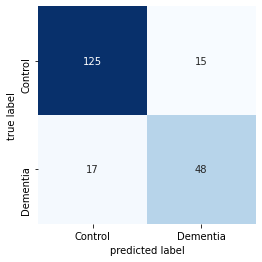

In [13]:
# rbf kernel
svc = SVM(verbose=True, kernel='rbf')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)
correct_preds = np.sum(preds == y_test)
print(f'Accuracy: {correct_preds/y_test.size}')
np_y_test = np.array(y_test).astype(int)
mat = confusion_matrix(np_y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label');